In [1]:
!pip install biopython openpyxl

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is de

In [2]:
import glob
import gzip
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from Bio import SeqIO
from pathlib import Path
from sklearn.metrics import roc_auc_score

from bionemo.noodles.nvfaidx import NvFaidx
from bionemo.testing.data.fasta import ALU_SEQUENCE, create_fasta_file


Outline:
1. Load evo2 model from hf checkpoints
1. Create fasta files for brca_1 data
2. Save to separate directory (one for reference, one for variance)
3. Use `predict` to score reference sequences
4. Use `predict` to score variant sequences
5. Compare (todo: ask John, my logic wrong for sure)
6. calculate auc
7. plot

## Load brca_1 data

In [3]:
# Download the data if not present
if not os.path.exists('brca1'):
    os.makedirs('brca1')

if not os.path.exists(os.path.join('brca1', '41586_2018_461_MOESM3_ESM.xlsx')):
    !wget https://github.com/ArcInstitute/evo2/raw/refs/heads/main/notebooks/brca1/41586_2018_461_MOESM3_ESM.xlsx -O brca1/41586_2018_461_MOESM3_ESM.xlsx

if not os.path.exists(os.path.join('brca1', 'GRCh37.p13_chr17.fna.gz')):
    !wget https://github.com/ArcInstitute/evo2/raw/refs/heads/main/notebooks/brca1/GRCh37.p13_chr17.fna.gz -O brca1/GRCh37.p13_chr17.fna.gz


In [4]:
brca1_df = pd.read_excel(
    os.path.join('brca1', '41586_2018_461_MOESM3_ESM.xlsx'),
    header=2,
)
brca1_df = brca1_df[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

# Rename columns
brca1_df.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)

# Convert to two-class system
brca1_df['class'] = brca1_df['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

brca1_df.head(10)

,chrom,pos,ref,alt,score,class
0,17,41276135,T,G,-0.372611,FUNC/INT
1,17,41276135,T,C,-0.045313,FUNC/INT
2,17,41276135,T,A,-0.108254,FUNC/INT
3,17,41276134,T,G,-0.277963,FUNC/INT
4,17,41276134,T,C,-0.388414,FUNC/INT
5,17,41276134,T,A,-0.280973,FUNC/INT
6,17,41276133,C,T,-0.973683,FUNC/INT
7,17,41276133,C,G,-0.373489,FUNC/INT
8,17,41276133,C,A,0.006314,FUNC/INT
9,17,41276132,A,T,-0.207552,FUNC/INT


In [5]:
WINDOW_SIZE = 8192

# Read the reference genome sequence of chromosome 17
with gzip.open(os.path.join('brca1', 'GRCh37.p13_chr17.fna.gz'), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_chr17 = str(record.seq)
        break

def parse_sequences(pos, ref, alt):
    """
    Parse reference and variant sequences from the reference genome sequence.
    """
    p = pos - 1 # Convert to 0-indexed position
    full_seq = seq_chr17

    ref_seq_start = max(0, p - WINDOW_SIZE//2)
    ref_seq_end = min(len(full_seq), p + WINDOW_SIZE//2)
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

In [6]:
# TODO: Delete this, just for parity
# Parse sequences for the first variant
row = brca1_df.iloc[0]
ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

print(row)
print('--')
print(f'Reference, SNV 0: ...{ref_seq[4082:4112]}...')
print(f'Variant, SNV 0:   ...{var_seq[4082:4112]}...')
print(len(ref_seq))

chrom          17
pos      41276135
ref             T
alt             G
score   -0.372611
class    FUNC/INT
Name: 0, dtype: object
--
Reference, SNV 0: ...TGTTCCAATGAACTTTAACACATTAGAAAA...
Variant, SNV 0:   ...TGTTCCAATGAACTGTAACACATTAGAAAA...
8192


In [7]:
# Build mappings of unique reference sequences
ref_seqs = []
ref_seq_to_index = {}

# Parse sequences and store indexes
ref_seq_indexes = []
var_seqs = []

for _, row in brca1_df.iterrows():
    ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

    # Get or create index for reference sequence
    if ref_seq not in ref_seq_to_index:
        ref_seq_to_index[ref_seq] = len(ref_seqs)
        ref_seqs.append(ref_seq)
    
    ref_seq_indexes.append(ref_seq_to_index[ref_seq])
    var_seqs.append(var_seq)

ref_seq_indexes = np.array(ref_seq_indexes)


print(f'Scoring likelihoods of {len(ref_seqs)} reference sequences with Evo 2...')

print(f'Scoring likelihoods of {len(var_seqs)} variant sequences with Evo 2...')

Scoring likelihoods of 1326 reference sequences with Evo 2...
Scoring likelihoods of 3893 variant sequences with Evo 2...


## Load Evo2

We'll load evo2 weights from hugging face.



In [8]:
!evo2_convert_to_nemo2 --model-path hf://arcinstitute/savanna_evo2_1b_base --model-size 1b --output-dir nemo2_evo2_1b_8k

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-26 22:42:53 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

We need to store a `Path` reference to where these checkpoints were saved so we can use them in the `predict` command later:

In [9]:
# todo: match path here with above command via shared string template
checkpoint_path = Path("nemo2_evo2_1b_8k")

### Save data to directories

Convert both the reference and variant fasta sequences to their own respective `.fasta` files.

In [10]:
SAMPLE_FRAC = 1.0
if SAMPLE_FRAC < 1.0:
    brca1_df = brca1_df.sample(frac=SAMPLE_FRAC).reset_index(drop=True)

In [11]:
from pathlib import Path

# Create output directory
output_dir = Path("brca1_fasta_files")
output_dir.mkdir(parents=True, exist_ok=True)

# Save reference and variant sequences to FASTA
ref_fasta_path = output_dir / "brca1_reference_sequences.fasta"
var_fasta_path = output_dir / "brca1_variant_sequences.fasta"

# Track unique sequences
ref_sequences = set()
var_sequences = set()
ref_seq_to_name = {}
# Store unique sequences with metadata for writing
ref_entries = []
var_entries = []
ref_names = []
var_names = []
# Collect unique reference and variant sequences
for idx, row in brca1_df.iterrows():
    ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'])

    # Add to sets to ensure uniqueness
    if ref_seq not in ref_sequences:
        ref_sequences.add(ref_seq)
        ref_name = f"BRCA1_ref_pos_{row['pos']}_{row['ref']}_class_{row['class']}"

        ref_entries.append(
            f">{ref_name}\n{ref_seq}\n"
        )
        ref_names.append(ref_name)
        ref_seq_to_name[ref_seq] = ref_name
    else:
        ref_name = ref_seq_to_name[ref_seq]
        ref_names.append(ref_name)
    if var_seq not in var_sequences:
        var_sequences.add(var_seq)
        var_name = f"BRCA1_var_pos_{row['pos']}_{row['ref']}to{row['alt']}_class_{row['class']}"

        var_entries.append(
            f">{var_name}\n{var_seq}\n"
        )
        var_names.append(var_name)
    else:
        assert False, "Duplicate variant sequence"

# Write unique sequences to FASTA files
with open(ref_fasta_path, "w") as f:
    f.writelines(ref_entries)

with open(var_fasta_path, "w") as f:
    f.writelines(var_entries)

# Print counts
print(f"Total unique reference sequences: {len(ref_sequences)}")
print(f"Total unique variant sequences: {len(var_sequences)}")


Total unique reference sequences: 1326
Total unique variant sequences: 3893


In [12]:
brca1_df['ref_fasta_name'] = ref_names
brca1_df['var_fasta_name'] = var_names

### Generate Samples of Reference/Variants.

The full samples takes too long for debugging

In [13]:
# Define output directories for prediction results
predict_ref_dir = output_dir / "reference_predictions"
predict_var_dir = output_dir / "variant_predictions"
predict_ref_dir.mkdir(parents=True, exist_ok=True)
predict_var_dir.mkdir(parents=True, exist_ok=True)

# Update predict commands to run on the full dataset
predict_ref_command = (
    f"predict_evo2 --fasta {ref_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_ref_dir} --model-size 1b --tensor-parallel-size 1 "
    "--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs"
)

predict_var_command = (
    f"predict_evo2 --fasta {var_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_var_dir} --model-size 1b --tensor-parallel-size 1 "
    "--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs"
)

In [14]:
!{predict_ref_command}

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-26 22:43:10 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

### Predict variant seqs (sample)

In [ ]:
!{predict_var_command}

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-02-26 22:50:48 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[WARNING  | py.warnings        ]: /usr/local/lib/python3.12/dist-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd

[WARNING  | py.warnings        ]: /usr/local/lib/python3.1

Ok, so far, we've turned the sequences into fasta files with unique headers per sequence.

Then, we ran predictions for these sequences.

Recall, we created seq_idx_maps that map FASTA sequence IDs (e.g. the sequence headers) to indices in the prediction arrays.

so, now we need to

1. load the prediction files and corresponding sequence id maps
2. map each sequence id to its original dataframe index
3. calculate the delta scores

So, let's load the prediction files and sequence id maps:

In [22]:
# Find and load prediction files
ref_pred_files = glob.glob(os.path.join(predict_ref_dir, "predictions__rank_*.pt"))
var_pred_files = glob.glob(os.path.join(predict_var_dir, "predictions__rank_*.pt"))

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(predict_ref_dir, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map = json.load(f)
with open(os.path.join(predict_var_dir, "seq_idx_map.json"), "r") as f:
    var_seq_idx_map = json.load(f)

# Load predictions
ref_preds = torch.load(ref_pred_files[0])
var_preds = torch.load(var_pred_files[0])

In [ ]:
ref_log_probs = []
var_log_probs = []
for _, row in brca1_df.iterrows():
    ref_name = row['ref_fasta_name']
    var_name = row['var_fasta_name']
    ref_log_probs.append(ref_preds['log_probs_seqs'][ref_seq_idx_map[ref_name]].item())
    var_log_probs.append(var_preds['log_probs_seqs'][var_seq_idx_map[var_name]].item())
brca1_df['ref_log_probs'] = ref_log_probs
brca1_df['var_log_probs'] = var_log_probs
# ideally probability of a broken variant is lower than a good one. So a bad var - good ref is negative.
brca1_df['evo2_delta_score'] = brca1_df['var_log_probs'] - brca1_df['ref_log_probs']
brca1_df.head()


,chrom,pos,ref,alt,score,class,ref_fasta_name,var_fasta_name,ref_log_probs,var_log_probs,diff_score,evo2_delta_score
0,17,41276062,T,A,-0.056789,FUNC/INT,BRCA1_ref_pos_41276062_T_class_FUNC/INT,BRCA1_var_pos_41276062_TtoA_class_FUNC/INT,-1.633416,-1.633648,-0.000232,-0.000232
1,17,41215890,C,T,-1.796453,LOF,BRCA1_ref_pos_41215890_C_class_LOF,BRCA1_var_pos_41215890_CtoT_class_LOF,-1.782346,-1.782195,0.000151,0.000151
2,17,41201178,G,A,-1.999553,LOF,BRCA1_ref_pos_41201178_G_class_LOF,BRCA1_var_pos_41201178_GtoA_class_LOF,-1.718188,-1.718212,-0.000023,-0.000023
3,17,41219643,G,C,-1.652875,LOF,BRCA1_ref_pos_41219643_G_class_LOF,BRCA1_var_pos_41219643_GtoC_class_LOF,-1.592031,-1.592255,-0.000224,-0.000224
4,17,41215913,T,A,-0.360066,FUNC/INT,BRCA1_ref_pos_41215913_T_class_FUNC/INT,BRCA1_var_pos_41215913_TtoA_class_FUNC/INT,-1.791920,-1.792505,-0.000585,-0.000585


In [40]:
# Calculate AUROC of zero-shot predictions
#  class 1 is LOF which is the bad thing. That means we expect this to be more negative.
y_true = (brca1_df['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1_df['evo2_delta_score'])
print(f'Zero-shot prediction AUROC: {auroc:.2}')

Zero-shot prediction AUROC: 0.41


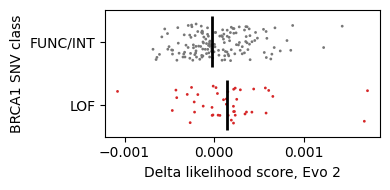

In [41]:
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1_df,
    x='evo2_delta_score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="evo2_delta_score",
            y="class",
            data=brca1_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()